# Refutation & Evaluation

**Objetivo:** Select the best estimate


# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config import TREATMENT, OUTCOME, SEED
from sklearn.model_selection import train_test_split

from utils.preprocessing import create_stratification_split_col
from utils.refutation import get_ci_e_values, get_ci_refutation_results, get_ci_qini

warnings.filterwarnings("ignore")

# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

In [3]:
step = 1
bin_edges = np.arange(0, 100+step, step)

In [4]:
n_resamples = 100

In [5]:
methods = ["logistic_reg", "s_learner", "aiptw"]

colors = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
    "aiptw": "lightblue"
}

In [6]:
step = 5
bin_edges_gps= np.arange(0, 100+step, step)

In [7]:
np.random.seed(SEED)

# Utils

# Data

In [8]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls

['n_loans',
 'n_cards',
 'loss_given_default',
 'debt_cirbe',
 'default_debt_amount',
 'years_since_default',
 'n_refin']

In [9]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['months_since_first_payment', 'years_history', 'n_accounts']

In [10]:
df_original = pd.read_parquet("data/synthetic_data.parquet")
df = df_original[controls + outcome_causes + [TREATMENT, OUTCOME]]
train_propagated = pd.read_parquet("data/synthetic_train_data_propagated.parquet")

# Split

In [11]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=strat_feature,
)

X_train_propagated, y_train_propagated = (
    train_propagated[controls + [TREATMENT]],
    train_propagated[[OUTCOME]],
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
print(X_train_propagated.shape, X_train.shape, X_test.shape)

(14387, 8) (12000, 11) (3000, 11)


# Refutation and Evaluation

In [12]:
monotone_constraints_list = []

for f in controls + outcome_causes + [TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

## Placebo Treatment Replacement

logistic_reg
s_learner
aiptw


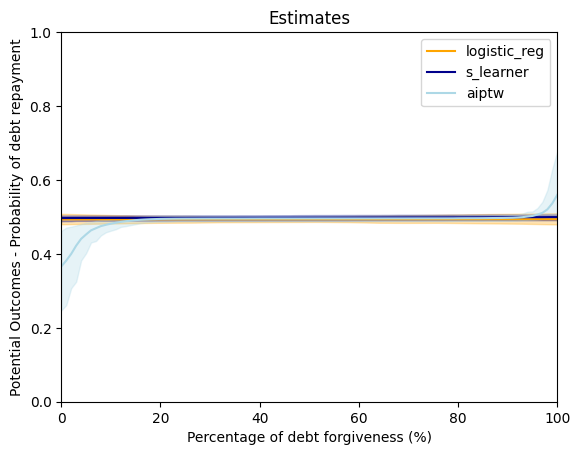

In [13]:
for est_method in methods:
    print(est_method)
    average_dose_response_curve_method, lower_ci, upper_ci = get_ci_refutation_results(
        refutation="placebo_treatment_replacement",
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_resamples,
        intervention_df=test.copy(),
        intervention_values=bin_edges,
        adjustment_set=controls+outcome_causes,
        outcome_causes=outcome_causes,
        n_variables_common_cause=5,
        confidence_level=0.95,
        bin_edges_gps=bin_edges_gps,
    )

    plt.plot(
        bin_edges,
        average_dose_response_curve_method,
        label=est_method,
        color=colors[est_method],
    )
    plt.fill_between(
        bin_edges,
        lower_ci,
        upper_ci,
        alpha=0.3,
        color=colors[est_method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Potential Outcomes - Probability of debt repayment")
plt.title("Estimates")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

## Random Common Cause

logistic_reg
s_learner
aiptw


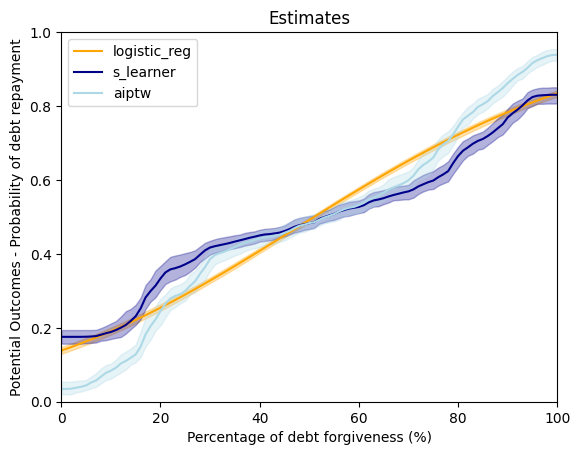

In [14]:
for est_method in methods:
    print(est_method)
    average_dose_response_curve_method, lower_ci, upper_ci = get_ci_refutation_results(
        refutation="random_common_cause",
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_resamples,
        intervention_df=test.copy(),
        intervention_values=bin_edges,
        adjustment_set=controls+outcome_causes,
        outcome_causes=outcome_causes,
        n_variables_common_cause=5,
        confidence_level=0.95,
        bin_edges_gps=bin_edges_gps,
        
    )
    plt.plot(
        bin_edges,
        average_dose_response_curve_method,
        label=est_method,
        color=colors[est_method],
    )
    plt.fill_between(
        bin_edges,
        lower_ci,
        upper_ci,
        alpha=0.3,
        color=colors[est_method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Potential Outcomes - Probability of debt repayment")
plt.title("Estimates")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

In [15]:
methods = ["logistic_reg", "s_learner"]

## E-values

Most expository treatments of e‑values focus on binary or discrete settings, or on testing a single parameter (like an average treatment effect). Extending to continuous treatments is feasible but is still an area of ongoing research.

logistic_reg
s_learner


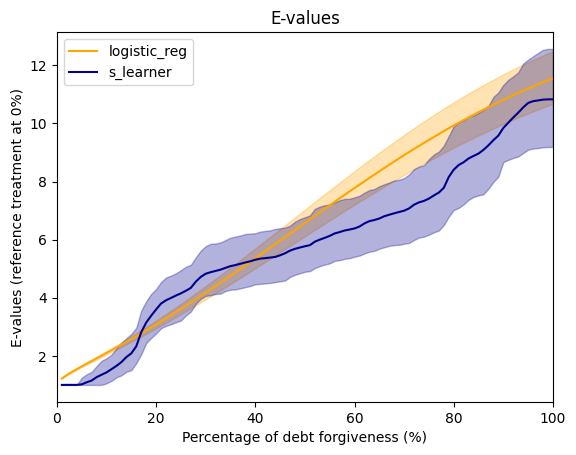

In [16]:
for est_method in methods:
    print(est_method)
    average_e_values_method, lower_ci, upper_ci =get_ci_e_values(
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_resamples,
        intervention_df=test.copy(),
        intervention_values=bin_edges,
        adjustment_set=controls+outcome_causes,
        outcome_causes=outcome_causes,
        confidence_level=0.95,
        bin_edges_gps=bin_edges_gps,
        monotone_constrains=monotone_constraints_list
    )

    plt.plot(
        bin_edges[1:],
        average_e_values_method,
        label=est_method,
        color=colors[est_method],
    )
    plt.fill_between(
        bin_edges[1:],
        lower_ci,
        upper_ci,
        alpha=0.3,
        color=colors[est_method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("E-values (reference treatment at 0%)")
plt.title("E-values")
plt.legend()
plt.xlim(0, 100)
plt.show()

## QINI curves

In [17]:
results = {
    'method': [],
    'average': [],
    'lower': [],
    'upper': []
}

for est_method in methods:
    print(est_method)
    average_qini, lower_ci, upper_ci = get_ci_qini(
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_resamples,
        intervention_df=test.copy(),
        delta=1,
        adjustment_set=controls+outcome_causes,
        outcome_causes=outcome_causes,
        confidence_level=0.95,
        bin_edges_gps=bin_edges_gps,
        monotone_constrains=monotone_constraints_list
    )
    print(average_qini, lower_ci, upper_ci)

    # Store results
    results['method'].append(est_method)
    results['average'].append(average_qini)
    results['lower'].append(lower_ci)
    results['upper'].append(upper_ci)


logistic_reg
0.5717771332255372 0.5672577408477559 0.57655143958904
s_learner
0.7879933509217504 0.7657569127546653 0.8103721743686446


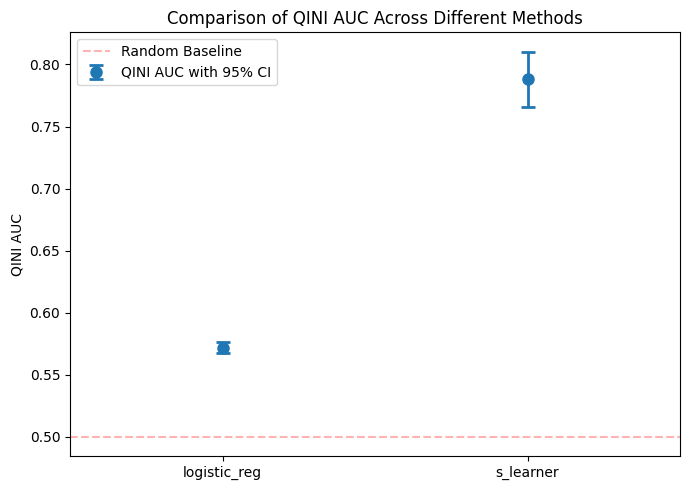


logistic_reg:
Average QINI AUC: 0.572

s_learner:
Average QINI AUC: 0.788


In [18]:
# Create the plot
plt.figure(figsize=(7, 5))

# Plot points and error bars
x = np.arange(len(results['method']))
plt.errorbar(
    x, 
    results['average'], 
    yerr=[np.array(results['average']) - np.array(results['lower']),
            np.array(results['upper']) - np.array(results['average'])],
    fmt='o', capsize=5, capthick=2, elinewidth=2, markersize=8,
    label='QINI AUC with 95% CI'
)

# Customize the plot
plt.xticks(x, results['method'], rotation=0, ha='center')
plt.xlim(-0.5, len(results['method']) - 0.5)  # Add padding on both sides
plt.ylabel('QINI AUC')
plt.title('Comparison of QINI AUC Across Different Methods')

# Add horizontal line at y=0.5 for reference
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Random Baseline')

plt.legend()
plt.tight_layout()
plt.show()

# Print numerical results
for i, method in enumerate(results['method']):
    print(f"\n{method}:")
    print(f"Average QINI AUC: {results['average'][i]:.3f}")